# FWHM Analysis

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib as mpl
from matplotlib import cm
import math
import scipy.optimize as opt
import os
from pathlib import Path



pixel_size = 3.45 # in micrometer
sigma_to_FWHM = 2.3548
Output_folder = 'Outputs'
mpl.rcParams.update({'font.size': 10})

In [2]:
def gaussian_function(x, a, b, sigma):
    return a * np.exp( (-1/2) * ((x-b) / sigma)**2)

In [3]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    theta = 0
    offset = 0
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [4]:
def gauss_2d_fit(input_beam_data, Amplitude, x0, y0, sigma_x, sigma_y, theta=0, offset=0, x_lim=[0,1439], y_lim=[0,1079], Output_folder = Output_folder, file_name="test",position = "L1"):
    #2D Fitting , position ekledim ,sol üstteki legendte ne yazacağı,

    initial_guess = (Amplitude, x0, y0, sigma_x, sigma_y, theta, offset) # (amplitude_x, amplitude_y, x0, y0, sigma_x, sigma_y, theta, offset)
    x = np.linspace(0, 1439, 1440); y = np.linspace(0, 1079, 1080)
    x, y = np.meshgrid(x, y)

    popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), input_beam_data.ravel(), p0=initial_guess, maxfev=10000)
    data_fitted = twoD_Gaussian((x, y), *popt)
    sigma_x = popt[3]; sigma_y = popt[4] 

    plt.figure(num=None, figsize=(8, 6), dpi=120)
    plt.imshow(input_beam_data.ravel().reshape(1080, 1440), cmap='gray', origin='lower',
        extent=(x.min(), x.max(), y.min(), y.max()))
    plt.contour(x, y, data_fitted.reshape(1080, 1440), 4, colors='g', linewidths=1, linestyles='dashed')#fitteki halka sayısı
    

    #plt.annotate("Sigma x = %f µm" %(sigma_x*pixel_size), (x_lim[0]+3, y_lim[0]+80), color="g")
    #plt.annotate("Sigma y = %f µm" %(sigma_y*pixel_size), (x_lim[0]+3, y_lim[0]+20), color="g")
    
    plt.xlabel("Pixel (3.45 µm)"); plt.ylabel("Pixel (3.45 µm)")
    
    plt.ylim(y_lim); plt.xlim(x_lim)
    
    #2 tane legend eklemek için değişiklerler yapıldı
    
    legend1 = plt.legend(title="FWHM\nx = %.1f µm\ny = %.1f µm"
               %(sigma_x*sigma_to_FWHM*pixel_size, sigma_y*sigma_to_FWHM*pixel_size),labelspacing=0.1)

    # Add the first legend to the current axes
    plt.gca().add_artist(legend1)
    
    # Create a new legend for specific lines
    legend2 = plt.legend(title=position, loc='upper left')

    # Add the second legend to the current axes
    plt.gca().add_artist(legend2)
    
    plt.show()
    
    return popt # returns the result of the fit to a 2d gaussian 

In [5]:
def find_index_of_max_intensity(list_to_check, item_to_find,input_beam_data,max_order = 1):
    indices = []
    max_array=[]
    list_to_check_int = [int(x) for x in list_to_check]
    for idx, value in enumerate(list_to_check_int):
        if value == item_to_find:
            indices.append(idx)
    for i in indices:
        max_array.append(max(input_beam_data[:,i])) 
    index = max_array.index(max(max_array))
    return indices[index]
    



## Without 50mm Lens Without 200 mm Lens

C:\Users\Nickolay\AppData\Local\Temp\ipykernel_16396\2447402142.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), input_beam_data.ravel(), p0=initial_guess, maxfev=10000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


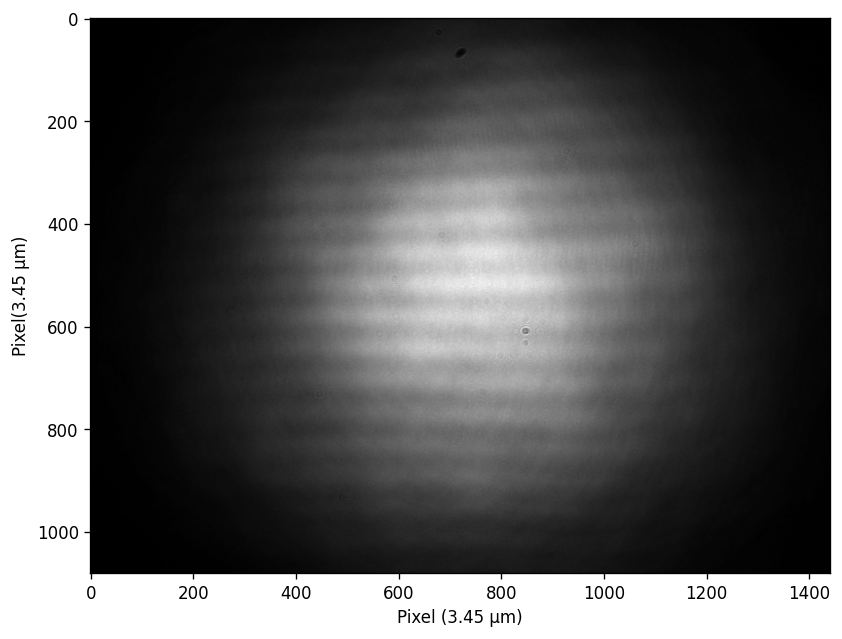

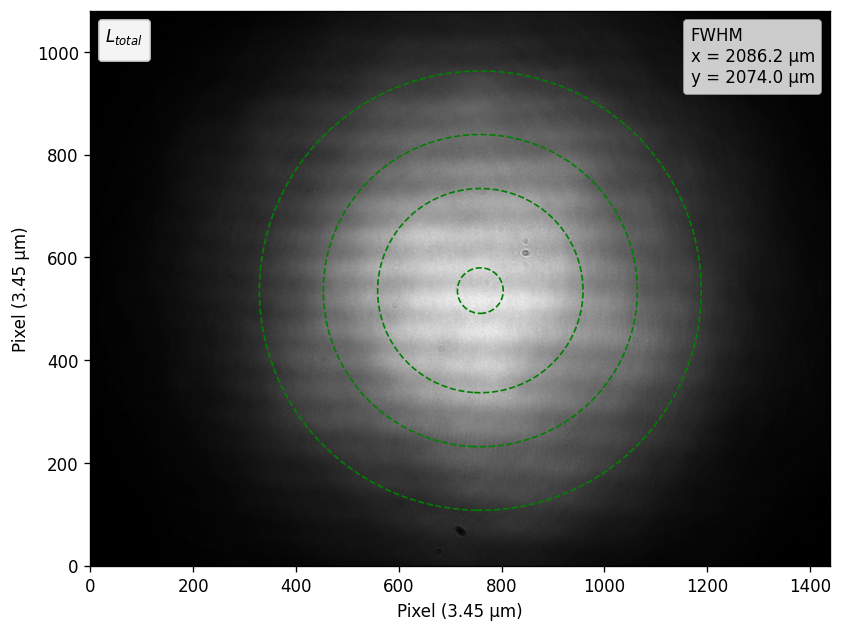

In [10]:
HERE = Path(".").resolve()   # current working directory
DATA_DIR = HERE / "data"   # adjust if your script isn't under scripts/
file_name_L_total = "2500ms_wout_50mm_lens_wout_200mm_lens_cam2_633nm_2_r.txt"
data_path = DATA_DIR / file_name_L_total

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Make sure the repo layout matches the expected structure."
    )

# --- Load data ---
input_beam_data = np.loadtxt(data_path)

input_beam_data_L_total = np.array(input_beam_data ,dtype="uint8")
input_beam_img = Image.fromarray(input_beam_data_L_total, mode="L")
plt.figure(num=None, figsize=(8, 6), dpi=120) 
plt.xlabel("Pixel (3.45 µm)"); plt.ylabel("Pixel(3.45 µm)")
plt.imshow(input_beam_img, cmap="gray")



#2D Fitting
popt = gauss_2d_fit(input_beam_data_L_total, Amplitude = 200, x0=800, y0=600, sigma_x= 250, sigma_y=250, theta=0, offset=0, file_name=file_name_L_total, position=r'$L_{total}$')
A_fit_L_total, x_fit_center_L_total, y_fit_center_L_total, sigma_x_fit_L_total, sigma_y_fit_L_total = popt[0:5]
x_fit_pixel_L_total, y_fit_pixel_L_total = round(x_fit_center_L_total), round(y_fit_center_L_total)


In [10]:
A_fit_L_total, x_fit_center_L_total, y_fit_center_L_total, sigma_x_fit_L_total, sigma_y_fit_L_total = popt[0:5]
x_fit_pixel_L_total, y_fit_pixel_L_total = round(x_fit_center_L_total), round(y_fit_center_L_total)

In [11]:
A_fit_L_total

162.43024743406156

## Without 50mm Lens with 200mm Lens

C:\Users\Nickolay\AppData\Local\Temp\ipykernel_16396\2447402142.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), input_beam_data.ravel(), p0=initial_guess, maxfev=10000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


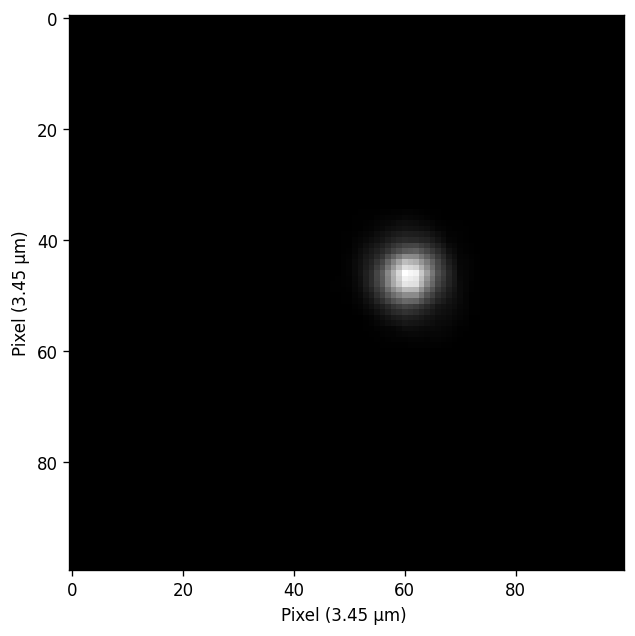

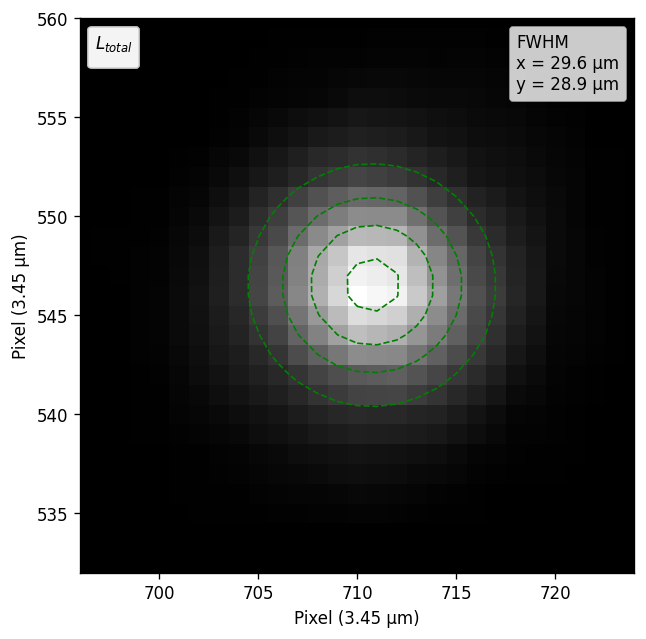

array([215.7592399 , 710.75800719, 546.5240324 ,   3.64778751,
         3.56214794,   0.        ,   0.        ])

In [17]:
file_name_L_total = "900ms_wout_50mm_lens_200mm_lens_cam2_633nm_2_r.txt"
data_path = DATA_DIR / file_name_L_total

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Make sure the repo layout matches the expected structure."
    )

# --- Load data ---
input_beam_data = np.loadtxt(data_path)
input_beam_data = np.array(input_beam_data ,dtype="uint8")
input_beam_img =Image.fromarray(input_beam_data[500:600,650:750],mode="L")
plt.figure(num=None, figsize=(8, 6), dpi=120)
plt.xlabel("Pixel (3.45 µm) "); plt.ylabel("Pixel (3.45 µm)")
plt.imshow(input_beam_img, cmap="gray")



#2D Fitting

gauss_2d_fit(input_beam_data, Amplitude = 10, x0=700, y0=550, sigma_x= 10, sigma_y=10, theta=0, offset=0,
x_lim = [696,724], y_lim = [532,560], file_name=file_name,position=r'$L_{total}$') 


## Before BS 

C:\Users\Nickolay\AppData\Local\Temp\ipykernel_16396\2447402142.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), input_beam_data.ravel(), p0=initial_guess, maxfev=10000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


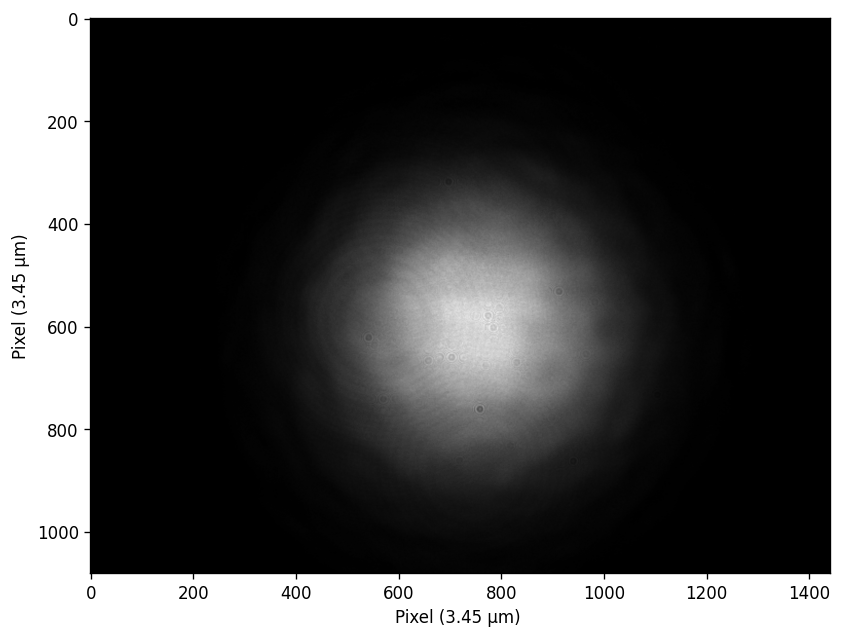

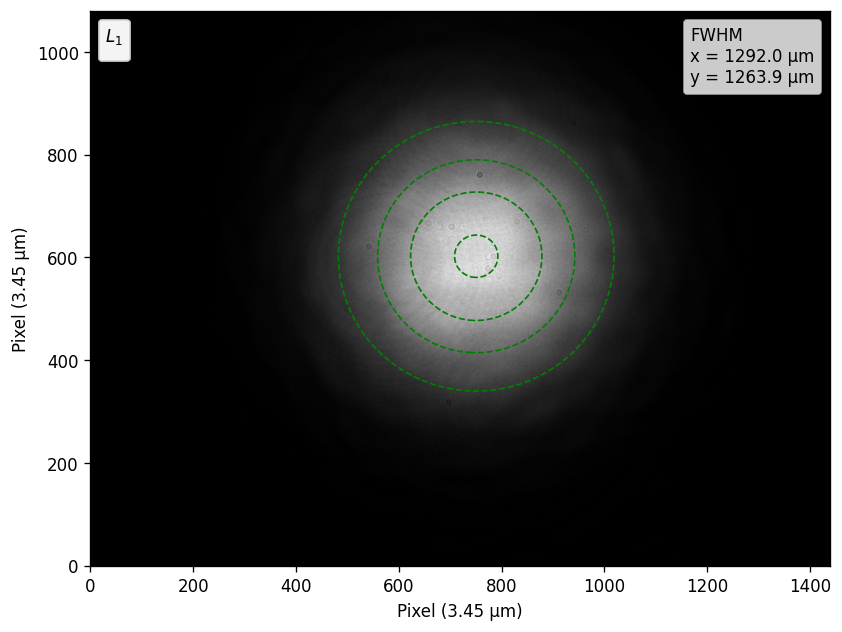

In [19]:
file_name_L1 = "7500ms_before_bs_cam1_633nm_r.txt"
data_path = DATA_DIR / file_name_L1

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Make sure the repo layout matches the expected structure."
    )
#Load data
input_beam_data = np.loadtxt(data_path)
input_beam_data_L1 = np.array(input_beam_data ,dtype="uint8")
input_beam_img_L1 =Image.fromarray(input_beam_data_L1,mode="L")
plt.figure(num=None, figsize=(8, 6), dpi=120)
plt.xlabel("Pixel (3.45 µm) "); plt.ylabel("Pixel (3.45 µm)")
plt.imshow(input_beam_img_L1, cmap="gray")




#2D Fitting

popt = gauss_2d_fit(input_beam_data_L1, Amplitude = 200, x0=750, y0=550, sigma_x= 150, sigma_y=150, theta=0, offset=0, file_name=file_name,position=r'$L_{1}$')
A_fit_L1, x_fit_center_L1, y_fit_center_L1, sigma_x_fit_L1, sigma_y_fit_L1 = popt[0:5]
x_fit_pixel_L1, y_fit_pixel_L1 = round(x_fit_center_L1), round(y_fit_center_L1)


## 50mm Lens without 200mm Lens

C:\Users\Nickolay\AppData\Local\Temp\ipykernel_16396\2447402142.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), input_beam_data.ravel(), p0=initial_guess, maxfev=10000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


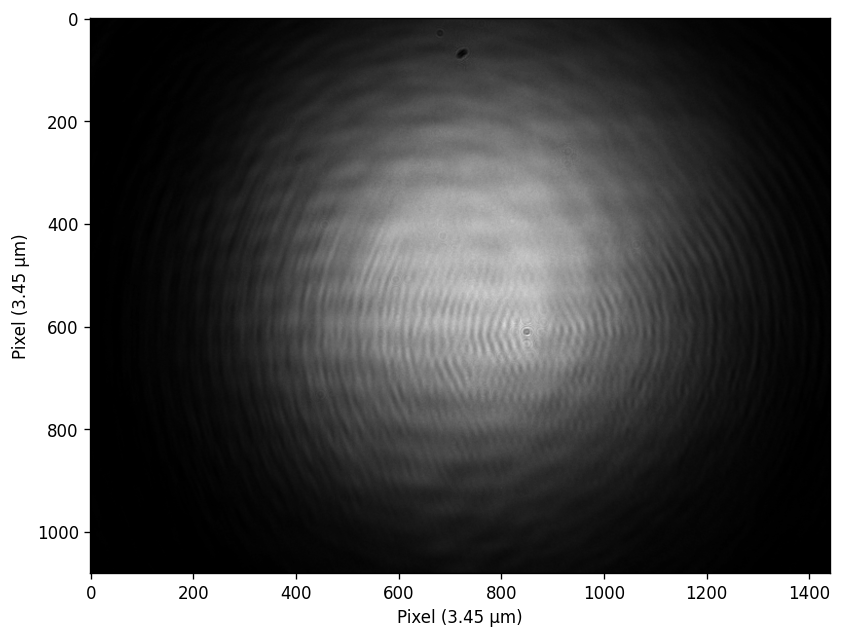

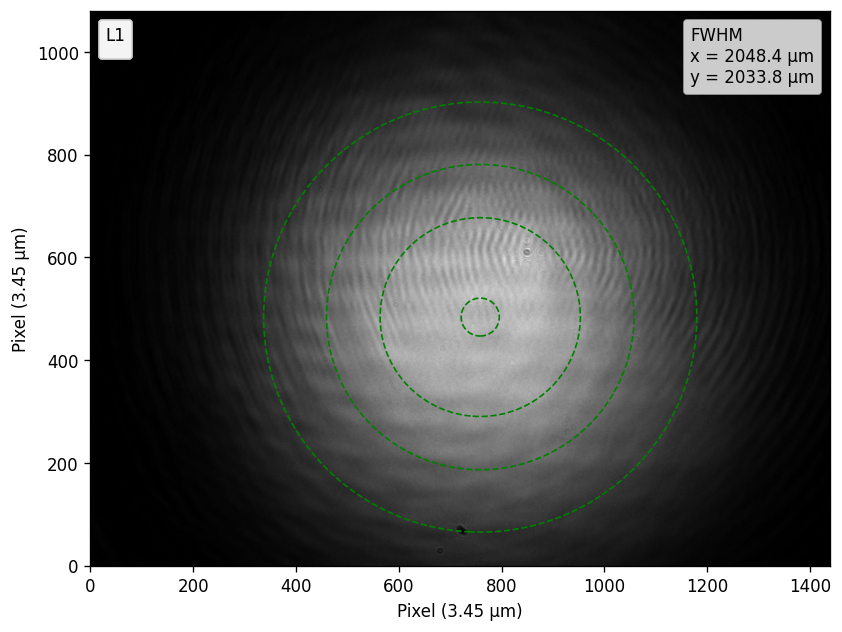

array([161.74396006, 758.58959142, 483.82863752, 252.13990301,
       250.33731   ,   0.        ,   0.        ])

In [20]:
file_name = "25000ms_50mm_lens_wout_200mm_lens_cam2_633nm_2_r.txt"

data_path = DATA_DIR / file_name

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Make sure the repo layout matches the expected structure."
    )
#Load data
input_beam_data = np.loadtxt(data_path)
input_beam_data = np.array(input_beam_data ,dtype="uint8")
input_beam_img =Image.fromarray(input_beam_data,mode="L")
plt.figure(num=None, figsize=(8, 6), dpi=120)
plt.xlabel("Pixel (3.45 µm)"); plt.ylabel("Pixel (3.45 µm)")
plt.imshow(input_beam_img, cmap="gray")




#2D Fitting
gauss_2d_fit(input_beam_data, Amplitude = 200, x0=750, y0=500, sigma_x= 250, sigma_y=250, theta=0, offset=0, file_name=file_name)

## 50mm Lens with 200mm Lens

C:\Users\Nickolay\AppData\Local\Temp\ipykernel_16396\2447402142.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), input_beam_data.ravel(), p0=initial_guess, maxfev=10000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


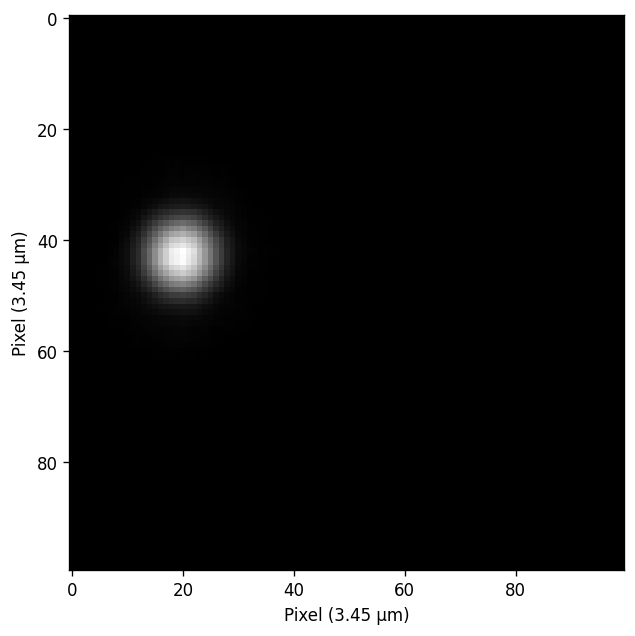

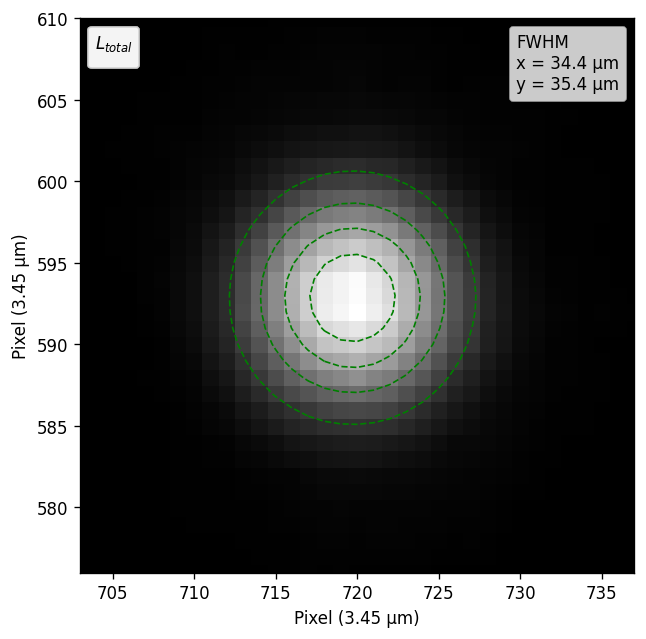

array([242.58747007, 719.71864296, 592.85342325,   4.24024912,
         4.36029948,   0.        ,   0.        ])

In [22]:
file_name = "1500ms_50mm_lens_200mm_lens_cam2_633nm_2_r.txt"

data_path = DATA_DIR / file_name

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Make sure the repo layout matches the expected structure."
    )
#Load data
input_beam_data = np.loadtxt(data_path)
input_beam_data = np.array(input_beam_data ,dtype="uint8")
input_beam_img =Image.fromarray(input_beam_data[550:650,700:800],mode="L")
plt.figure(num=None, figsize=(8, 6), dpi=120)
plt.xlabel("Pixel (3.45 µm)"); plt.ylabel("Pixel (3.45 µm)")
plt.imshow(input_beam_img, cmap="gray")



#2D Fitting
gauss_2d_fit(input_beam_data, Amplitude = 10, x0=720, y0=590, sigma_x= 10, sigma_y=10, theta=0, offset=0, 
             x_lim=[703,737], y_lim=[576,610], file_name=file_name,position=r'$L_{total}$')


## At 50mm Lens

C:\Users\Nickolay\AppData\Local\Temp\ipykernel_16396\2447402142.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), input_beam_data.ravel(), p0=initial_guess, maxfev=10000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


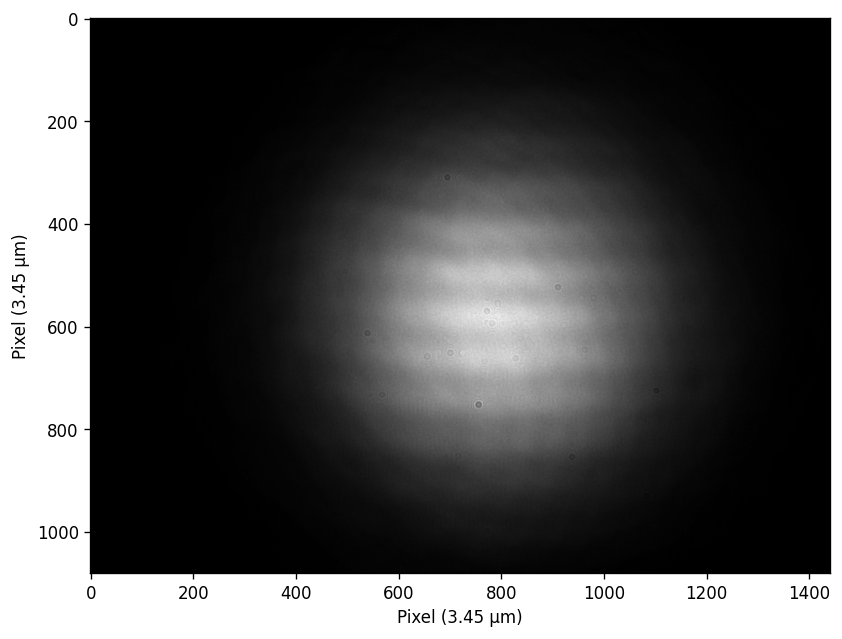

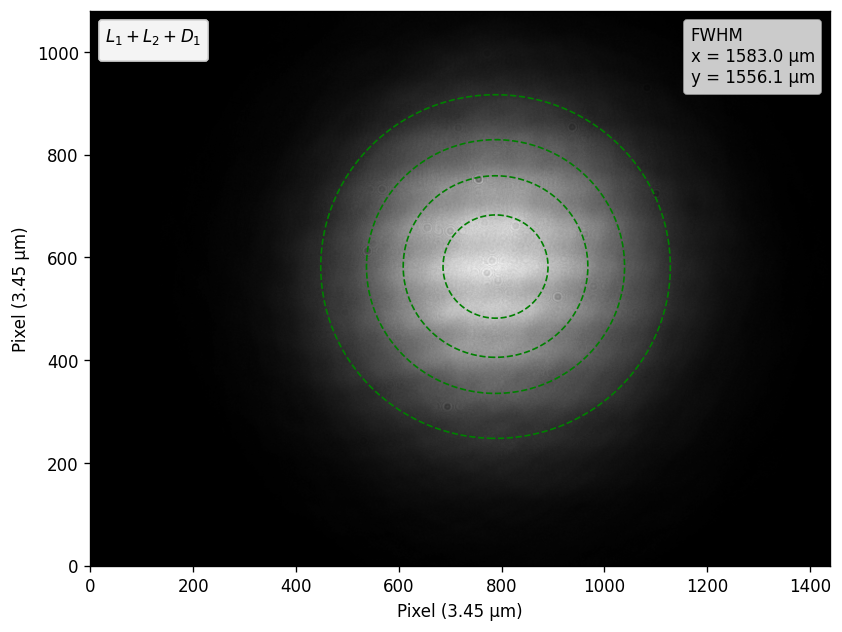

array([183.58053901, 788.3624678 , 582.15821819, 194.84726154,
       191.54703361,   0.        ,   0.        ])

In [24]:
file_name = "24000ms_at_objective_cam1_633nm_r.txt"
data_path = DATA_DIR / file_name

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Make sure the repo layout matches the expected structure."
    )
#Load data
input_beam_data = np.loadtxt(data_path)

input_beam_data = np.array(input_beam_data ,dtype="uint8")
input_beam_img =Image.fromarray(input_beam_data,mode="L")
plt.figure(num=None, figsize=(8, 6), dpi=120)
plt.xlabel("Pixel (3.45 µm)"); plt.ylabel("Pixel (3.45 µm)")
plt.imshow(input_beam_img, cmap="gray")



#2D Fitting

gauss_2d_fit(input_beam_data, Amplitude = 200, x0=800, y0=550, sigma_x= 200, sigma_y=200, theta=0, offset=0, file_name=file_name,position=r'$L_{1}+L_{2}+D_{1}$')



# Simulation

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)

figsize = (6,5); 

# Fonts
plt_label_size = 12; legend_font_size = plt_label_size*1 ; 

# Line thicknesses
axes_linewidth = 3; lines_linewidth = axes_linewidth; 

# Tick sizes
major_tick_size = 6; minor_tick_size = major_tick_size / 2; tick_width = major_tick_size / 4

kw_args = { 'figure.figsize': figsize, # 'font.family': 'cursive', # 'font.monospace': 'Fixed',
           
            'axes.linewidth': axes_linewidth, 'lines.linewidth': lines_linewidth, 'axes.labelsize': plt_label_size, 
           
            'axes.grid': True, 'grid.alpha': 0.25, 'grid.color':  'gray', 'grid.linestyle': '--',
           
            'legend.fontsize': legend_font_size,  'legend.title_fontsize': legend_font_size, 
            
           
            'xtick.direction':'in', 'xtick.major.size': major_tick_size, 'xtick.major.width': tick_width, 'xtick.major.pad': major_tick_size, 
            'xtick.minor.size': minor_tick_size, 'xtick.minor.width': tick_width, 'xtick.labelsize': plt_label_size, 'xtick.minor.visible': True,
            'xtick.color': 'k', 'xtick.top': True,
             
            'ytick.direction':'in', 'ytick.major.size': major_tick_size, 'ytick.major.width': tick_width, 'ytick.major.pad': major_tick_size,
            'ytick.minor.size': minor_tick_size, 'ytick.minor.width': tick_width, 'ytick.labelsize': plt_label_size,  'ytick.minor.visible': True,
            'ytick.color': 'k', 'ytick.right': True,
           
            'savefig.bbox': "tight"
            
           }

plt.rcParams.update(kw_args)

In [20]:
#Import
from diffractio import degrees, mm, plt, np, um
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.utils_drawing import draw_several_fields
from diffractio.utils_optics import beam_width_1D, FWHM2D, MTF_ideal, MTF_parameters,FWHM1D
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_masks_XZ import Scalar_mask_XZ
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_XY import Scalar_mask_XY
import math
import matplotlib.pyplot as plt
import matplotlib

In [21]:
# Parameters 

#Gaussian Beam

wavelength =  0.6328 * um
w0 = 0.35821143204247774 # mm https://www.thorlabs.com/thorproduct.cfm?partnumber=HNL100R#ad-image-0

#Sample Size

num_sample=  500000


#Second Lens 

second_lens_diameter = 25.4 * mm
range_of_second_lens = np.linspace(-second_lens_diameter/2 , second_lens_diameter/2 , num_sample)
focal_length_second_lens = 200 * mm

second_lens = Scalar_mask_X(x=range_of_second_lens, wavelength=wavelength)
second_lens.lens(x0=0.0, focal=focal_length_second_lens, radius=second_lens_diameter/ 2)


#First Lens

first_lens_diameter = 25.4 * mm
focal_length_first_lens = 50 * mm

first_lens = Scalar_mask_X(x=range_of_second_lens, wavelength=wavelength)
first_lens.lens(x0=0.0, focal=focal_length_first_lens, radius=first_lens_diameter/ 2)


array([1.      , 0.999992, 0.999984, ..., 0.999984, 0.999992, 1.      ])

## Laser Output

In [22]:
laser_output = Scalar_source_X(x=range_of_second_lens, wavelength=wavelength)
laser_output.gauss_beam(A=1,x0=0,z0=0*mm, w0= w0 * mm,theta=0 * degrees) 

## Without 50mm Lens Without 200 mm Lens

Good result: factor 2115.20


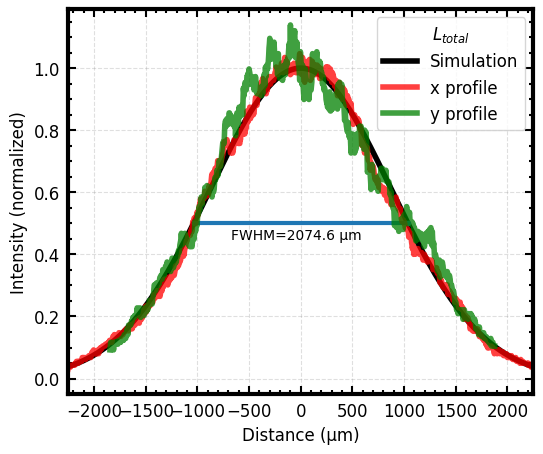

In [63]:
L_total=3068*mm

beam_L_total = laser_output.RS(z=L_total)
fwhm_beam_L_total = FWHM1D(beam_L_total.x,beam_L_total.intensity(), has_draw= False)
max_L_total_intensity=max(beam_L_total.intensity())

plt.plot(beam_L_total.x, beam_L_total.intensity()/max_L_total_intensity, color="k", lw=4, label ="Simulation")

#FWHM LINE
x1, y1 = [-fwhm_beam_L_total/2, fwhm_beam_L_total/2], [0.5,0.5] #[max(np.abs(beam_L_total.u)**2)/2, max(np.abs(beam_L_total.u)**2)/2]
plt.plot(x1, y1, marker = '.')
plt.text(x1[0]*.65, y1[0]*.9, s= 'FWHM=%.1f µm' %fwhm_beam_L_total)

plt.plot(np.arange(-x_fit_pixel_L_total*pixel_size, (1440-x_fit_pixel_L_total)*pixel_size, pixel_size), input_beam_data_L_total[y_fit_pixel_L_total,:]/(1*A_fit_L_total), label="x profile", alpha=0.75, color="r", lw=4)
plt.plot(np.arange(-(y_fit_pixel_L_total)*pixel_size, (1080-y_fit_pixel_L_total)*pixel_size, pixel_size), input_beam_data_L_total[:,x_fit_pixel_L_total+5]/(1*A_fit_L_total), label="y profile", alpha=0.75, color="g", lw=4)


#plt.title("Optic Path Length")
plt.xlabel("Distance (µm)")
plt.ylabel("Intensity (normalized)")
plt.xlim(-2250,2250); plt.ylim(-0.05, 1.19)
plt.legend(title=r'$L_{total}$')


#Saving photo

file_name = "wout_50mm_lens_wout_200mm_lens_sim.txt"
plt.savefig(f"{Output_folder}/" + file_name.replace(".txt", ".png"), bbox_inches='tight')

plt.show()



## Before BS 

Good result: factor 1244.06


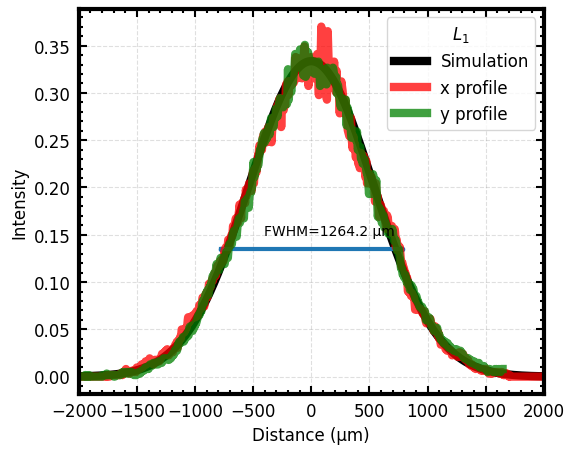

In [52]:
L1=1800*mm

beam_L1 = laser_output.RS(z=L1)
fwhm_beam_L1 = FWHM1D(beam_L1.x,beam_L1.intensity(),has_draw= False)

plt.plot(beam_L1.x, beam_L1.intensity(), color="k", lw=6, label ="Simulation")

plt.plot(x1, y1, marker = '.')
plt.plot(np.arange(-x_fit_pixel_L1*pixel_size, (1440-x_fit_pixel_L1)*pixel_size, pixel_size), input_beam_data_L1[y_fit_pixel_L1,:]/(3*A_fit_L1), label="x profile", alpha=0.75, color="r", lw=6)
plt.plot(np.arange(-(y_fit_pixel_L1)*pixel_size, (1080-y_fit_pixel_L1)*pixel_size, pixel_size), input_beam_data_L1[:,x_fit_pixel_L1]/(3*A_fit_L1), label="y profile", alpha=0.75, color="g", lw=6)

#FWHM LINE
x1, y1 = [-fwhm_beam_L1/2, fwhm_beam_L1/2], [max(np.abs(beam_L1.u)**2)/2, max(np.abs(beam_L1.u)**2)/2]
plt.text(x1[0]*.65, y1[0]*.9, s= 'FWHM=%.1f µm' %fwhm_beam_L1)


#plt.title("Optic Path Length")
plt.xlabel("Distance (µm)")
plt.ylabel("Intensity (normalized)")
plt.xlim(-2000,2000)
plt.legend(title=r'$L_{1}$')


#Saving Photo
file_name = "before_bs_sim.txt"
plt.savefig(f"{Output_folder}/" + file_name.replace(".txt", ".png"), bbox_inches='tight')

plt.show()



### Figures for Different Locations

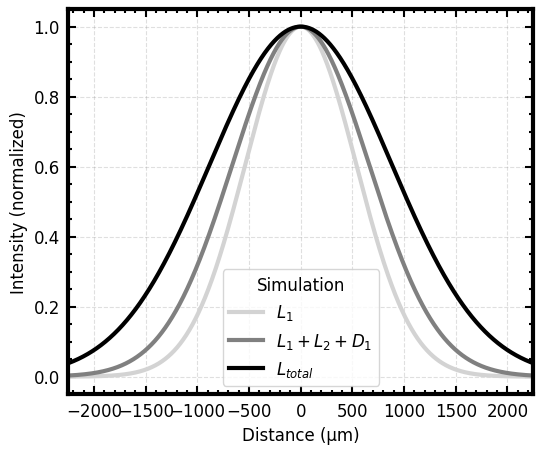

In [67]:
plt.plot(beam_L1.x, beam_L1.intensity()/max(beam_L1.intensity()),color="lightgray",label="$L_{1}$") #,label="$L_{1}$: %.1f" %fwhm_beam_L1
plt.plot(at_objective.x, at_objective.intensity()/max(at_objective.intensity()), color="gray", label=r"$L_{1}+L_{2}+D_{1}$") #, label=r'$L_{1}+L_{2}+D_{1}$: %.1f' %fwhm_at_objective
plt.plot(beam_L_total.x, beam_L_total.intensity()/max_L_total_intensity, color="k",label=r"$L_{total}$") #,label=r'$L_{total}$: %.1f' %fwhm_beam_L_total

plt.xlabel("Distance (µm)")
plt.ylabel("Intensity (normalized)")
plt.xlim(-2250,2250)
plt.legend(title="Simulation")

#Saving Photo
file_name = "different locations.txt"
plt.savefig(f"{Output_folder}/" + file_name.replace(".txt", ".png"), bbox_inches='tight')
plt.show()